In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from imblearn.over_sampling import SMOTE
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import torch
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import joblib

In [4]:
# 1. Charger le fichier CSV en vérifiant les colonnes
df = pd.read_csv('DATA2.csv',sep=';')

# Vérifier les noms de colonnes existants
print("Colonnes disponibles:", df.columns.tolist())

# 2. Vérifier que les colonnes nécessaires existent
colonnes_requises = ['NIN_ok', 'cn_valid', 'similarity_score']
for col in colonnes_requises:
    if col not in df.columns:
        raise ValueError(f"Colonne manquante: {col}. Veuillez vérifier votre fichier CSV.")

# 3. Fonction de détermination des violations (version robuste)
def determiner_violation(row):
    try:
        nin_ok = int(row['NIN_ok'])
        cn_valid = int(row['cn_valid'])
        similarity = int(row['similarity_score'])
        
        violations = []
        
        # Règles métiers
        if nin_ok == 0:
            violations.append("NIN incorrecte")
        
        if cn_valid == 0:
            violations.append("carte expirée")
        
        if similarity <= 60:
            violations.append("similarité faible")
        
        if not violations:
            return "Aucune violation"
            
        return " et ".join(violations)
        
    except Exception as e:
        print(f"Erreur sur la ligne {row.name}: {str(e)}")
        return "Erreur de calcul"

# 4. Application de la fonction
df['violation_reason'] = df.apply(determiner_violation, axis=1)

# 5. Vérification des résultats
print("\nExemples de résultats:")
print(df[['NIN_ok', 'cn_valid', 'similarity_score', 'violation_reason']].head(10))

# 6. Statistiques des violations
print("\nDistribution des raisons de violation:")
print(df['violation_reason'].value_counts())

# 7. Sauvegarde du fichier
df.to_csv('DATA2.csv', index=False, sep=';', encoding='utf-8-sig')
print("\nFichier sauvegardé avec succès.")

Colonnes disponibles: ['id_fact', 'cust_id', 'nin', 'MSISDN', 'status', 'status_date', 'Birth_date', 'age_sub', 'Gender', 'Nationality', 'Subscriber_type', 'id_type', 'subscription_type', 'tarrif_profile', 'ICC', 'type_sim', 'category', 'connection_type', 'source', 'CHANNEL', 'Activation_Date', 'First_Call_Date', 'Last_Call_Date', 'ID_doc', 'Document_Validation_2G', 'Document_Validation_3G', 'Document_Validation_4G', 'Document_stamped', 'document_scaned_status', 'Document_Validation_Date', 'DOC_SCN_DT', 'pdv_sk', 'PoS_ID', 'DOC_VAL_USR', 'DOK_SCN_USR', 'BU', 'localisation_sk', 'Postal_ID', 'Province', 'City', 'Street', 'id_date', 'full_date', 'year', 'mois', 'lib_mois', 'jours', 'lib_jour', 'object_id', 'NIN_ok', 'DOB_ok', 'minor_ok', 'cn_valid', 'similarity_score', 'ocr_violation', 'id_operation', 'type_d_operation', 'similarity_score_bin', 'violation_reason', 'temps_moyen_appel', 'temps_moyen_traitement', 'reactivite_client', 'Revenue_Last_2_Months', 'Revenue_Last_12_Months', 'ARPU_L

In [24]:
df= pd.read_csv('DATA2.csv', sep=';')

In [25]:
df.drop(columns=['ocr_violation','type_d_operation', 'id_operation'], inplace=True, errors='ignore')

In [13]:
df.to_csv('DATA2.csv', sep=';')

In [5]:
class Fuzzifier(nn.Module):
    def __init__(self, input_dim, centers=3):
        super().__init__()
        self.centers = nn.Parameter(torch.linspace(0, 1, centers).repeat(input_dim, 1), requires_grad=True)
        self.sigma = nn.Parameter(torch.ones(input_dim, centers) * 0.1, requires_grad=True)

    def forward(self, x):
        x = x.unsqueeze(-1)  # (batch, features, 1)
        diff = (x - self.centers) ** 2
        return torch.exp(-diff / (2 * self.sigma ** 2))  # (batch, features, centers)

# --- Logic Attention Layer avec pooling ---
class LogicAttention(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.query = nn.Linear(input_dim, embed_dim)
        self.key = nn.Linear(input_dim, embed_dim)
        self.value = nn.Linear(input_dim, embed_dim)
        self.scale = embed_dim ** 0.5

    def forward(self, x):
        Q, K, V = self.query(x), self.key(x), self.value(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        weights = F.softmax(scores, dim=-1)
        attended = torch.matmul(weights, V)
        pooled = attended.mean(dim=1)  # Global average pooling
        return pooled, weights

# --- Main Logic Attention Network ---
class LogicAttentionNet(nn.Module):
    def __init__(self, input_dim, embed_dim=64, num_classes=5, centers=3):
        super().__init__()
        self.fuzzifier = Fuzzifier(input_dim, centers)
        self.linear_pre = nn.Linear(input_dim * centers, input_dim)
        self.logic_attention = LogicAttention(input_dim, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        fuzzified = self.fuzzifier(x)  # (batch, features, centers)
        flat_fuzz = fuzzified.flatten(start_dim=1)  # (batch, features * centers)
        embed = self.linear_pre(flat_fuzz)  # (batch, features)
        pooled, attn_weights = self.logic_attention(embed.unsqueeze(1))  # (batch, 1, features) -> pour compatibilité
        out = self.mlp(pooled)
        return out, attn_weights


In [6]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.num_pipe = None
        self.encoder = None
        self.num_cols = []
        self.cat_cols = []

    def fit(self, X, y=None):
        X = X.copy()
        self.num_cols = X.select_dtypes(include=np.number).columns.tolist()
        self.cat_cols = X.select_dtypes(include='object').columns.tolist()

        # Pipeline pour colonnes numériques
        self.num_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        self.num_pipe.fit(X[self.num_cols])

        # Encoder pour colonnes catégorielles
        df_cat = X[self.cat_cols].fillna(X[self.cat_cols].mode().iloc[0])
        if y is None:
            y = np.zeros(len(X))  # y factice
        self.encoder = ce.LeaveOneOutEncoder(cols=self.cat_cols)
        self.encoder.fit(df_cat, y)

        return self

    def transform(self, X):
        X = X.copy()

        # Colonnes numériques
        X_num = pd.DataFrame(self.num_pipe.transform(X[self.num_cols]), columns=self.num_cols, index=X.index)

        # Colonnes catégorielles
        df_cat = X[self.cat_cols].fillna(X[self.cat_cols].mode().iloc[0])
        X_cat = self.encoder.transform(df_cat)

        # Concaténation
        X_final = pd.concat([X_num, X_cat], axis=1)

        return X_final

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)


class DataPreprocessor:
    def __init__(self):
        self.X_processor = Preprocessor()
        self.y_encoder = LabelEncoder()

    def fit(self, X, y):
        # Fit Preprocessor et LabelEncoder
        self.X_processor.fit(X, y)
        self.y_encoder.fit(y)
        return self

    def transform(self, X, y=None):
        X_transformed = self.X_processor.transform(X)
        y_transformed = self.y_encoder.transform(y) if y is not None else None
        return X_transformed, y_transformed

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X, y)

    def inverse_transform_y(self, y_encoded):
        return self.y_encoder.inverse_transform(y_encoded)


In [26]:
df.columns

Index(['id_fact', 'cust_id', 'nin', 'MSISDN', 'status', 'status_date',
       'Birth_date', 'age_sub', 'Gender', 'Nationality', 'Subscriber_type',
       'id_type', 'subscription_type', 'tarrif_profile', 'ICC', 'type_sim',
       'category', 'connection_type', 'source', 'CHANNEL', 'Activation_Date',
       'First_Call_Date', 'Last_Call_Date', 'ID_doc', 'Document_Validation_2G',
       'Document_Validation_3G', 'Document_Validation_4G', 'Document_stamped',
       'document_scaned_status', 'Document_Validation_Date', 'DOC_SCN_DT',
       'pdv_sk', 'PoS_ID', 'DOC_VAL_USR', 'DOK_SCN_USR', 'BU',
       'localisation_sk', 'Postal_ID', 'Province', 'City', 'Street', 'id_date',
       'full_date', 'year', 'mois', 'lib_mois', 'jours', 'lib_jour',
       'object_id', 'NIN_ok', 'DOB_ok', 'minor_ok', 'cn_valid',
       'similarity_score', 'similarity_score_bin', 'violation_reason',
       'temps_moyen_appel', 'temps_moyen_traitement', 'reactivite_client',
       'Revenue_Last_2_Months', 'Revenue_La

In [27]:
len(df.columns)

66

In [28]:
# --- Charger le CSV ---
# df = pd.read_csv("DATA2.csv", sep=';')

# --- Séparer features et target (garder X en DataFrame) ---
X = df.drop('violation_reason', axis=1)
y = df['violation_reason']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# Prétraitement
dp = DataPreprocessor()
X_train_processed, y_train_encoded = dp.fit_transform(X_resampled, y_resampled)
X_test_processed, y_test_encoded = dp.transform(X_test, y_test)
joblib.dump(dp, "preprocessor.joblib")
# --- Dataset PyTorch ---
class CSVDataset(Dataset):
    def __init__(self, X, y):
        # Convert DataFrame to numpy array first, then to tensor
        self.X = torch.tensor(X.values if isinstance(X, pd.DataFrame) else X, 
                             dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_ds = CSVDataset(X_train_processed, y_train_encoded)
test_ds = CSVDataset(X_test_processed, y_test_encoded)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)


In [29]:
input_dim = X_train_processed.shape[1]
num_classes = len(np.unique(y_train_encoded))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Initialiser le modèle ===
model = LogicAttentionNet(input_dim=input_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 10

# === Fonction d'entraînement ===
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    all_preds, all_targets = [], []

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs, _ = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    return total_loss / len(loader), acc

# === Fonction d'évaluation ===
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs, _ = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    return total_loss / len(loader), acc

# === Boucle d'entraînement ===
best_acc = 0.0
best_logloss = float('inf') 
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.4f}")

    # Sauvegarder le meilleur modèle
    if test_acc > best_acc or (test_acc == best_acc and test_loss < best_logloss):
        best_acc = test_acc
        best_logloss = test_loss
        torch.save(model.state_dict(), "best_logic_attention_model.pt")
        print("  --> New best model saved!")

print(f"  Best model saved! (Acc: {test_acc:.4f}, LogLoss: {test_loss:.4f})")


Epoch 1/10
  Train Loss: 0.3762 | Train Acc: 0.8820
  Test  Loss: 0.0147 | Test  Acc: 0.9953
  --> New best model saved!
Epoch 2/10
  Train Loss: 0.0016 | Train Acc: 0.9999
  Test  Loss: 0.0064 | Test  Acc: 0.9992
  --> New best model saved!
Epoch 3/10
  Train Loss: 0.0004 | Train Acc: 1.0000
  Test  Loss: 0.0062 | Test  Acc: 0.9992
  --> New best model saved!
Epoch 4/10
  Train Loss: 0.0003 | Train Acc: 1.0000
  Test  Loss: 0.0068 | Test  Acc: 0.9984
Epoch 5/10
  Train Loss: 0.0002 | Train Acc: 1.0000
  Test  Loss: 0.0066 | Test  Acc: 0.9992
Epoch 6/10
  Train Loss: 0.0001 | Train Acc: 1.0000
  Test  Loss: 0.0057 | Test  Acc: 0.9992
  --> New best model saved!
Epoch 7/10
  Train Loss: 0.0001 | Train Acc: 1.0000
  Test  Loss: 0.0045 | Test  Acc: 0.9992
  --> New best model saved!
Epoch 8/10
  Train Loss: 0.0001 | Train Acc: 1.0000
  Test  Loss: 0.0037 | Test  Acc: 0.9992
  --> New best model saved!
Epoch 9/10
  Train Loss: 0.0001 | Train Acc: 1.0000
  Test  Loss: 0.0033 | Test  Acc: 0.

Epoch 1/20
  Train Loss: 0.3975 | Train Acc: 0.8680
  Test  Loss: 0.0253 | Test  Acc: 0.9938
  --> New best model saved!
Epoch 2/20
  Train Loss: 0.0020 | Train Acc: 0.9998
  Test  Loss: 0.0167 | Test  Acc: 0.9969
  --> New best model saved!
Epoch 3/20
  Train Loss: 0.0009 | Train Acc: 0.9999
  Test  Loss: 0.0182 | Test  Acc: 0.9969
Epoch 4/20
  Train Loss: 0.0003 | Train Acc: 1.0000
  Test  Loss: 0.0132 | Test  Acc: 0.9969
  --> New best model saved!
Epoch 5/20
  Train Loss: 0.0003 | Train Acc: 1.0000
  Test  Loss: 0.0085 | Test  Acc: 0.9969
  --> New best model saved!
Epoch 6/20
  Train Loss: 0.0001 | Train Acc: 1.0000
  Test  Loss: 0.0062 | Test  Acc: 0.9984
  --> New best model saved!
Epoch 7/20
  Train Loss: 0.0003 | Train Acc: 1.0000
  Test  Loss: 0.0046 | Test  Acc: 0.9984
  --> New best model saved!
Epoch 8/20
  Train Loss: 0.0001 | Train Acc: 1.0000
  Test  Loss: 0.0052 | Test  Acc: 0.9992
  --> New best model saved!
Epoch 9/20
  Train Loss: 0.0001 | Train Acc: 1.0000
  Test  

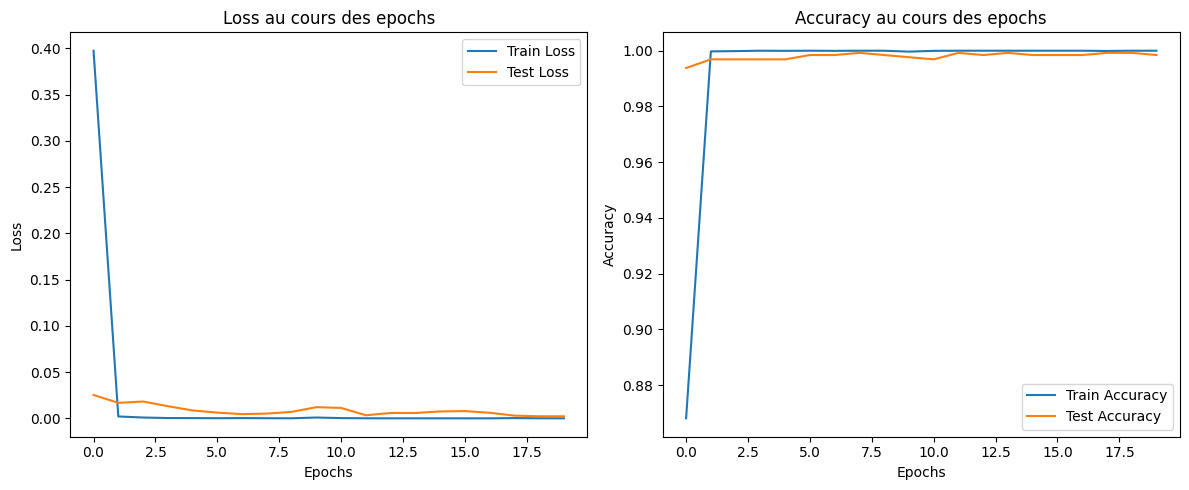

In [9]:
import matplotlib.pyplot as plt

input_dim = X_train_processed.shape[1]
num_classes = len(np.unique(y_train_encoded))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Initialiser le modèle ===
model = LogicAttentionNet(input_dim=input_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 20

# Listes pour stocker les métriques
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# === Boucle d'entraînement ===
best_acc = 0.0
best_logloss = float('inf') 
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    
    # Stocker les métriques
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.4f}")

    # Sauvegarder le meilleur modèle
    if test_acc > best_acc or (test_acc == best_acc and test_loss < best_logloss):
        best_acc = test_acc
        best_logloss = test_loss
        torch.save(model.state_dict(), "best_logic_attention_model.pt")
        print("  --> New best model saved!")

print(f"  Best model saved! (Acc: {test_acc:.4f}, LogLoss: {test_loss:.4f})")

# Tracer les courbes
plt.figure(figsize=(12, 5))

# Courbe de loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss au cours des epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy au cours des epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')  # Sauvegarder le graphique
plt.show()

In [12]:
# Passage en mode évaluation
model.eval()

# Collecte des prédictions et probabilités
all_preds = []
all_probs = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits, _ = model(X_batch)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.append(preds)
        all_probs.append(probs)
        all_targets.append(y_batch)

all_preds = torch.cat(all_preds).cpu().numpy()
all_probs = torch.cat(all_probs).cpu().numpy()
all_targets = torch.cat(all_targets).cpu().numpy()


Classification Report :
                                                      precision    recall  f1-score   support

                                    Aucune violation       1.00      1.00      1.00       380
                                      NIN incorrecte       1.00      1.00      1.00       669
                     NIN incorrecte et carte expirée       1.00      1.00      1.00       121
NIN incorrecte et carte expirée et similarité faible       1.00      0.93      0.96        14
                 NIN incorrecte et similarité faible       1.00      1.00      1.00        30
                                       carte expirée       1.00      1.00      1.00        51
                  carte expirée et similarité faible       1.00      1.00      1.00         5
                                   similarité faible       1.00      1.00      1.00        19

                                            accuracy                           1.00      1289
                                  

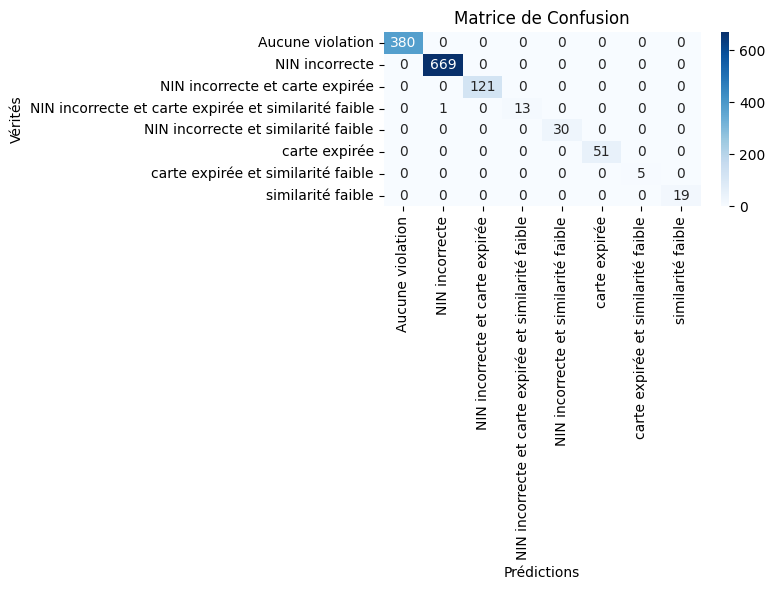

In [24]:
dp = DataPreprocessor()
dp.fit(X_train, y_train)  # X_train et y_train sont vos données d'entraînement originales

# Transformation des données de test
X_test_processed, y_test_encoded = dp.transform(X_test, y_test)

# Binarisation pour ROC
y_test_bin = label_binarize(all_targets, classes=np.arange(len(dp.y_encoder.classes_)))

# Rapport de classification CORRIGÉ (utilisation de dp.y_encoder au lieu de le)
print("Classification Report :")
print(classification_report(all_targets, all_preds, target_names=dp.y_encoder.classes_))

# Matrice de confusion CORRIGÉE
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=dp.y_encoder.classes_, 
            yticklabels=dp.y_encoder.classes_)
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.tight_layout()
plt.show()

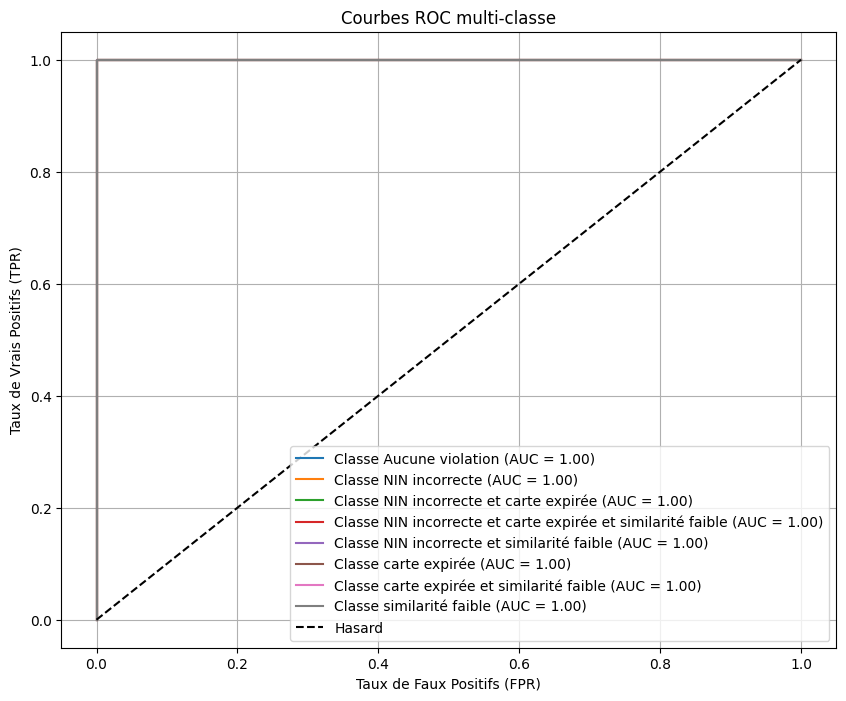

In [14]:
# 1. D'abord, assurez-vous d'avoir fit le DataPreprocessor avec vos données d'entraînement
dp = DataPreprocessor()
dp.fit(X_train, y_train)  # X_train et y_train sont vos données d'entraînement originales

# 2. Ensuite, transformez vos données de test (si nécessaire)
X_test_processed, y_test_encoded = dp.transform(X_test, y_test)

# 3. Maintenant vous pouvez utiliser y_encoder.classes_
y_test_bin = label_binarize(all_targets, classes=np.arange(len(dp.y_encoder.classes_)))

# Courbes ROC par classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(dp.y_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro & Macro
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Affichage
plt.figure(figsize=(10, 8))
for i in range(len(dp.y_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], 
             label=f'Classe {dp.y_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Hasard')
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbes ROC multi-classe")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
data = {
    'id_fact': [6460], 'cust_id': [1222401523278], 'nin': [1111122223333444],
    'MSISDN': [774155131], 'status': ['ACT'], 'status_date': ['2025-01-01 00:00:00'],
    'Birth_date': ['2003-04-26 00:00:00'], 'age_sub': [22], 'Gender': ['FEMALE'],
    'Nationality': ['DZ'], 'Subscriber_type': ['INDIVIDUAL'], 'id_type': ['NATIONAL_I'],
    'subscription_type': ['PREPAID'], 'tarrif_profile': ['DJEZZY LEGEND_4G'],
    'ICC': ['3243785502934991111112222_774155131'], 'type_sim': ['USIM'], 'category': ['New'],
    'connection_type': ['4G'], 'source': ['Source2'], 'CHANNEL': ['SNOC'],
    'Activation_Date': ['2025-01-08 00:00:00'], 'First_Call_Date': ['2025-01-08 00:40:00'],
    'Last_Call_Date': ['2025-05-09 16:00:00'], 'ID_doc': ['79944268739945444331748811111111'],
    'Document_Validation_2G': ['NO'], 'Document_Validation_3G': ['NO'], 
    'Document_Validation_4G': ['YES'], 'Document_stamped': ['YES'],
    'document_scaned_status': ['YES'], 'Document_Validation_Date': ['2025-01-08 00:10:00'],
    'DOC_SCN_DT': ['2025-01-08 00:05:00'], 'pdv_sk': [223], 'PoS_ID': ['CH033428368069'],
    'DOC_VAL_USR': ['CH033428368069VAL1'], 'DOK_SCN_USR': ['CH033428368069SCN1'],
    'BU': ['ALGER'], 'localisation_sk': ['218'], 'Postal_ID': [16050], 
    'Province': ['ALGER'], 'City': ['DRARIA'], 'Street': ['BOUDJEMA TEMIME DRARIA N57'],
    'id_date': [20250108000500], 'full_date': ['2025-01-08 00:05:00'], 'year': [2025],
    'mois': [1], 'lib_mois': ['Janvier'], 'jours': [8], 'lib_jour': ['Mercredi'],
    'object_id': ['SNOC-1222401523278-774155131'], 'NIN_ok': [1], 'DOB_ok': [1],
    'minor_ok': [0], 'cn_valid': [1], 'similarity_score': [95], 'ocr_violation': [50],
    'id_operation': [1], 'type_d_operation': ['reject'], 'similarity_score_bin': [1],
    'temps_moyen_appel': [54000.21], 'temps_moyen_traitement': [5.0], 
    'reactivite_client': [40.00], 'Revenue_Last_2_Months': [3000.00],
    'Revenue_Last_12_Months': [18000.00], 'ARPU_Last_2_Months': [15000.00],
    'segment_value': ['H VHV]>4000['], 'client_haut_revenue': [1],
    'doc_scan_avant_activation': [1], 'score_confiance': [1]
}
# --- Étape 1 : Convertir l'instance en DataFrame ---
new_data = pd.DataFrame(data)

# --- Étape 2 : Appliquer le même prétraitement ---
# X_new_processed, _ = dp.transform(new_data)
dp = joblib.load("preprocessor.joblib")  # même objet que pendant le fit
X_new_processed, _ = dp.transform(new_data)
# --- Étape 3 : Conversion en tenseur ---
X_tensor = torch.tensor(X_new_processed.values, dtype=torch.float32).to(device)

# --- Étape 4 : Charger le modèle entraîné ---
model = LogicAttentionNet(input_dim=X_new_processed.shape[1], num_classes=num_classes).to(device)
model.load_state_dict(torch.load("best_logic_attention_model.pt", map_location=device))
model.eval()

# --- Étape 5 : Prédire ---
with torch.no_grad():
    outputs, attn_weights = model(X_tensor)
    pred_class = outputs.argmax(dim=1).cpu().numpy()[0]

# --- Étape 6 : Décoder la classe ---
pred_label = dp.inverse_transform_y([pred_class])[0]

print(f"Classe prédite : {pred_label}")
